## 1. Load Libraries

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import cv2
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load Dataset

In [3]:
%pip install keras.engine

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement keras.engine (from versions: none)
ERROR: No matching distribution found for keras.engine


In [7]:

# define function to load train, test, and validation datasets
def load_dataset(path):
    """
    Loads the images from path.
    
    Args
    ----------
    path : String
        Holds the path of the dataset

    Returns
    -------
    Array
        Two numpy arrays that holds the images and the targets.
    """
    data = load_files(path)
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return face_files, face_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('images/train')
valid_files, valid_targets = load_dataset('images/valid')
test_files, test_targets = load_dataset('images/test')


# load list of dog names
face_names = [item[20:-1] for item in sorted(glob("images/train/*/"))]

# print statistics about the dataset
print('There are %d total face names.' % len(face_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))


There are 2 total face names.
There are 471 total face images.

There are 120 training face images.
There are 351 validation face images.
There are 0 test face images.


## 3. Training Visualization 

In [8]:
def performance_viz(history, xc_length):
    """
    Visualizes training history.
    
    Args
    ----------
    history : Keras object
        Holds the training history

    Returns
    -------
    Empty.
    """
    train_loss = history_aug.history['loss']
    val_loss = history_aug.history['val_loss']
    train_acc = history_aug.history['acc']
    val_acc = history_aug.history['val_acc']
    xc = range(xc_length)

    # Visualize Train vs Validation loss
    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train_loss vs Val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    print (plt.style.available)
    plt.style.use(['classic'])
    plt.show()
    # Visualize Train vs Validation Accuracy
    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.title('Train Acc vs Val Acc')
    plt.grid(True)
    plt.legend(['Train','Val'],loc=4)
    plt.style.use(['classic'])
    plt.show()

## 4. Load Weights

In [9]:
# Loads the weights and Evaluates the model's performance
def load_weights(model,file_name, test, test_targets):
    """
    Load the best weights saved from during training the proposed CNN architecture and evaluates the model's performance.
    
    Args
    ----------
    model : Keras object
        Holds the proposed CNN architecture.
    
    test : Numpy array
        Holds the test images.
    
    test_targets : Numpy Array
        Holds the images labels in a string format.
    
    Returns
    -------
    Empty.
    """
    model.load_weights('saved_models/' + file_name) # Load weights

    score = model.evaluate(test, test_targets, verbose=0)
    print('\n', 'Test accuracy:', score[1])

## 5. Data Exploration

In [12]:
#plt.bar(range(2), [len(train_files_orig),len(train_files_fake)])

## 6. Image Sample

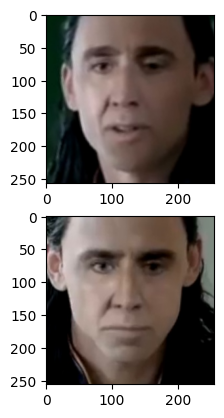

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load original image
img_1 = mpimg.imread(train_files[0])

# Load fake image
img_2 = mpimg.imread(train_files[2])

# Print a subplot
plt.figure(1)
plt.subplot(211)
plt.imshow(img_1)

plt.subplot(212)
plt.imshow(img_2)
plt.show()

## 7. Pre-process the Data

### Tensor Creation

In [14]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    """
    Creates tensor of a single image to be consumed by the CNN architecture.
    
    Args
    ----------
    img_path : Numpy Array
        Holds the images paths.
    
    Returns
    -------
    Tensor : Tensorflow object.
        Holds the converted image.
    """
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """
    Creates tensors of images to be consumed by the CNN architecture.
    
    Args
    ----------
    img_path : Numpy Array
        Holds the images paths.
    
    Returns
    -------
    list_of_tensors : Tensorflow object.
        Holds the converted images.
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Resize, Rescale and Gray Scale Conversion

In [15]:
def resize_img(img, max_dim=96):
    large_axis = max((0, 1), key=lambda x: img.size[x])
    scalar = max_dim / float(img.size[large_axis])
    resized = img.resize(
        (int(img.size[0] * scalar), int(img.size[1] * scalar)))
    return resized


def load_image_data(id_list, max_dim=96, center=True):   
    X = np.empty((len(id_list), max_dim, max_dim, 1))
    for i, idnum in enumerate(id_list):
        x = image.load_img(
            (str(idnum)), grayscale=True)
        x = image.img_to_array(resize_img(x, max_dim=max_dim))
        height = x.shape[0]
        width = x.shape[1]
        if center:
            h1 = int((max_dim - height) / 2)
            h2 = h1 + height
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (height, width)
        X[i, h1:h2, w1:w2, :] = x
    return np.around(X / 255.0)

### Image Augmentation For The Fake Photos

In [20]:
from keras_preprocessing.image import ImageDataGenerator
def aug():
    """
    Auguments the images in case the dataset of images is small.
    
    Args
    ----------
    Empty.
    
    Returns
    -------
    datagen_train : ImageDatagenerator Object.
        Holds the augumented train dataset.
    """
    # create and configure augmented image generator
    datagen_train = ImageDataGenerator(
        width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
        height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
        #horizontal_flip=True,
        #vertical_flip = True,
        shear_range=0.15,
        zoom_range=0.2) # randomly flip images horizontally
        # fit augmented image generator on data
    return datagen_train
    #datagen_valid.fit(valid_tensors)


## 8. Custom Architecture

In [23]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers import BatchNormalization
"""
    Propsoed CNN architecture.
    
"""

model = Sequential()

# Pamameters Initialization
input_shape = (96, 96, 1)
activation = 'relu'
padding = 'same'
droprate = 0.1
epsilon=0.001

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))


model.add(Conv2D(filters=32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=128, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=256, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=512, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())
#model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.5))
          
#model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dropout(droprate))
model.add(Dense(2, activation='softmax'))

model.summary() # Summary of the architecture

d:\python\envs\tensorflowgpu\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 96, 96, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 512)      │             

 Total params: 1,577,542 (6.02 MB)

 Trainable params: 1,575,524 (6.01 MB)

 Non-trainable params: 2,018 (7.88 KB)

## Model Compile

In [26]:
# Parameters Initialization
from keras.optimizers import rmsprop,SGD,Adam,Adadelta

from keras.optimizers import RMSprop

# Define your optimizer
optimizer = RMSprop(lr=0.0001)

# Compile your model, passing the optimizer identifier as a string
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


## Load Data

In [30]:
from keras.preprocessing import image
import numpy as np

def load_image_data(id_list, max_dim, center):
    X = np.empty((len(id_list), max_dim, max_dim, 1))
    for i, idnum in enumerate(id_list):
        x = image.load_img(str(idnum))
        x = x.convert('L')  # Convert image to grayscale
        x = image.img_to_array(resize_img(x, max_dim=max_dim))
        height = x.shape[0]
        width = x.shape[1]
        if center:
            h1 = int((max_dim - height) / 2)
            h2 = h1 + height
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
            X[i, h1:h2, w1:w2, 0:1] = x
        else:
            X[i, 0:height, 0:width, 0:1] = x
    return X
train_X = load_image_data(train_files,max_dim=224, center=True)
valid_X = load_image_data(valid_files,max_dim=224, center=True)
test_X = load_image_data(test_files,max_dim=224, center=True)

train_augmented_X = aug()

## Train Model

### Train Model on Original Data

In [32]:
from keras.callbacks import ModelCheckpoint,EarlyStopping  

batch_size = 10
epochs = 100

checkpointer = ModelCheckpoint(filepath='saved_models/weights.custom.best.hdf5', 
                               monitor='val_loss',verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto')
hist = model.fit(train_X, train_targets,
                    steps_per_epoch=train_X.shape[0] ,
                    epochs=epochs, verbose=1, callbacks=[checkpointer,early_stopping],
                    validation_data=(valid_X, valid_targets),
                    validation_steps=valid_X.shape[0] )



ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=saved_models/weights.custom.best.hdf5

### Evaluate Model on Orgiginal Data

In [ ]:
load_weights(model_custom,'weights.custom.best.hdf5', test_X, test_targets)

### Train Model on Augumented Data

In [95]:
batch_size = 20
epochs = 25

from keras.callbacks import ModelCheckpoint,EarlyStopping  
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.aug.best.hdf5', 
                               monitor='val_loss',verbose=1, save_best_only=True)
history_aug = model_custom.fit_generator(train_augmented_X.flow(train_X, train_targets, batch_size=batch_size,shuffle=True),
                    steps_per_epoch=train_X.shape[0] ,
                    epochs=epochs, verbose=1, callbacks=[checkpointer,early_stopping],
                    validation_data=(valid_X, valid_targets),
                    validation_steps=valid_X.shape[0] )

Epoch 1/25


204/427 [=============>................] - ETA: 1:25:29 - loss: 0.7600 - acc: 0.35 - ETA: 45:40 - loss: 0.6676 - acc: 0.5750 - ETA: 32:01 - loss: 0.6866 - acc: 0.60 - ETA: 24:56 - loss: 0.6680 - acc: 0.62 - ETA: 20:43 - loss: 0.6497 - acc: 0.62 - ETA: 17:51 - loss: 0.6721 - acc: 0.60 - ETA: 15:44 - loss: 0.6745 - acc: 0.60 - ETA: 14:06 - loss: 0.6799 - acc: 0.59 - ETA: 12:48 - loss: 0.6668 - acc: 0.62 - ETA: 11:36 - loss: 0.6545 - acc: 0.61 - ETA: 10:46 - loss: 0.6327 - acc: 0.63 - ETA: 10:03 - loss: 0.6482 - acc: 0.63 - ETA: 9:27 - loss: 0.6469 - acc: 0.6478 - ETA: 8:55 - loss: 0.6554 - acc: 0.637 - ETA: 8:28 - loss: 0.6532 - acc: 0.638 - ETA: 8:04 - loss: 0.6621 - acc: 0.635 - ETA: 7:43 - loss: 0.6633 - acc: 0.633 - ETA: 7:24 - loss: 0.6615 - acc: 0.634 - ETA: 7:07 - loss: 0.6576 - acc: 0.635 - ETA: 6:52 - loss: 0.6501 - acc: 0.646 - ETA: 6:36 - loss: 0.6445 - acc: 0.653 - ETA: 6:22 - loss: 0.6374 - acc: 0.662 - ETA: 6:10 - loss: 0.6476 - acc: 0.655 - ETA: 5:59 - loss: 0.6445 - acc: 

204/427 [=============>................] - ETA: 7:36 - loss: 0.2591 - acc: 0.950 - ETA: 6:31 - loss: 0.3383 - acc: 0.875 - ETA: 5:54 - loss: 0.3611 - acc: 0.850 - ETA: 5:26 - loss: 0.3382 - acc: 0.875 - ETA: 4:58 - loss: 0.3334 - acc: 0.870 - ETA: 4:41 - loss: 0.3157 - acc: 0.883 - ETA: 4:32 - loss: 0.3134 - acc: 0.871 - ETA: 4:19 - loss: 0.3254 - acc: 0.868 - ETA: 4:07 - loss: 0.3300 - acc: 0.861 - ETA: 3:52 - loss: 0.3389 - acc: 0.860 - ETA: 3:41 - loss: 0.3504 - acc: 0.854 - ETA: 3:31 - loss: 0.3518 - acc: 0.850 - ETA: 3:24 - loss: 0.3467 - acc: 0.857 - ETA: 3:17 - loss: 0.3556 - acc: 0.857 - ETA: 3:10 - loss: 0.3496 - acc: 0.860 - ETA: 3:04 - loss: 0.3472 - acc: 0.859 - ETA: 2:59 - loss: 0.3469 - acc: 0.858 - ETA: 2:51 - loss: 0.3520 - acc: 0.858 - ETA: 2:47 - loss: 0.3554 - acc: 0.858 - ETA: 2:43 - loss: 0.3518 - acc: 0.860 - ETA: 2:43 - loss: 0.3515 - acc: 0.859 - ETA: 2:43 - loss: 0.3569 - acc: 0.854 - ETA: 2:42 - loss: 0.3577 - acc: 0.854 - ETA: 2:42 - loss: 0.3633 - acc: 0.854

426/427 [============================>.] - ETA: 2s - loss: 0.3315 - acc: 0.873 - ETA: 1s - loss: 0.3318 - acc: 0.873 - ETA: 1s - loss: 0.3318 - acc: 0.873 - ETA: 1s - loss: 0.3325 - acc: 0.872 - ETA: 1s - loss: 0.3323 - acc: 0.872 - ETA: 0s - loss: 0.3321 - acc: 0.872 - ETA: 0s - loss: 0.3317 - acc: 0.872 - ETA: 0s - loss: 0.3314 - acc: 0.8732
Epoch 00002: val_loss improved from 0.44760 to 0.42865, saving model to saved_models/weights.aug.best.hdf5
427/427 [==============================] - 119s 278ms/step - loss: 0.3313 - acc: 0.8732 - val_loss: 0.4286 - val_acc: 0.8376
Epoch 3/25


205/427 [=============>................] - ETA: 1:41 - loss: 0.4080 - acc: 0.850 - ETA: 1:42 - loss: 0.3019 - acc: 0.900 - ETA: 1:41 - loss: 0.2935 - acc: 0.900 - ETA: 1:42 - loss: 0.3238 - acc: 0.900 - ETA: 1:45 - loss: 0.3326 - acc: 0.890 - ETA: 1:47 - loss: 0.3188 - acc: 0.900 - ETA: 1:47 - loss: 0.3227 - acc: 0.892 - ETA: 1:46 - loss: 0.3303 - acc: 0.893 - ETA: 1:46 - loss: 0.3239 - acc: 0.894 - ETA: 1:45 - loss: 0.3092 - acc: 0.900 - ETA: 1:44 - loss: 0.2970 - acc: 0.904 - ETA: 1:44 - loss: 0.3010 - acc: 0.900 - ETA: 1:44 - loss: 0.3106 - acc: 0.892 - ETA: 1:43 - loss: 0.3154 - acc: 0.889 - ETA: 1:43 - loss: 0.3199 - acc: 0.886 - ETA: 1:44 - loss: 0.3209 - acc: 0.887 - ETA: 1:44 - loss: 0.3084 - acc: 0.894 - ETA: 1:44 - loss: 0.3169 - acc: 0.888 - ETA: 1:41 - loss: 0.3325 - acc: 0.887 - ETA: 1:40 - loss: 0.3493 - acc: 0.877 - ETA: 1:40 - loss: 0.3447 - acc: 0.881 - ETA: 1:39 - loss: 0.3394 - acc: 0.884 - ETA: 1:39 - loss: 0.3363 - acc: 0.882 - ETA: 1:39 - loss: 0.3277 - acc: 0.885

205/427 [=============>................] - ETA: 1:44 - loss: 0.2071 - acc: 0.850 - ETA: 1:44 - loss: 0.1972 - acc: 0.900 - ETA: 1:43 - loss: 0.2417 - acc: 0.850 - ETA: 1:43 - loss: 0.2368 - acc: 0.875 - ETA: 1:44 - loss: 0.2260 - acc: 0.880 - ETA: 1:44 - loss: 0.2414 - acc: 0.875 - ETA: 1:45 - loss: 0.2382 - acc: 0.885 - ETA: 1:46 - loss: 0.2444 - acc: 0.881 - ETA: 1:47 - loss: 0.2443 - acc: 0.888 - ETA: 1:47 - loss: 0.2560 - acc: 0.880 - ETA: 1:46 - loss: 0.2505 - acc: 0.881 - ETA: 1:45 - loss: 0.2550 - acc: 0.883 - ETA: 1:44 - loss: 0.2484 - acc: 0.884 - ETA: 1:43 - loss: 0.2497 - acc: 0.882 - ETA: 1:43 - loss: 0.2514 - acc: 0.883 - ETA: 1:42 - loss: 0.2536 - acc: 0.884 - ETA: 1:42 - loss: 0.2662 - acc: 0.888 - ETA: 1:43 - loss: 0.2557 - acc: 0.894 - ETA: 1:42 - loss: 0.2657 - acc: 0.892 - ETA: 1:42 - loss: 0.2691 - acc: 0.892 - ETA: 1:42 - loss: 0.2663 - acc: 0.892 - ETA: 1:42 - loss: 0.2698 - acc: 0.888 - ETA: 1:42 - loss: 0.2737 - acc: 0.889 - ETA: 1:42 - loss: 0.2708 - acc: 0.889

426/427 [============================>.] - ETA: 1s - loss: 0.2592 - acc: 0.904 - ETA: 1s - loss: 0.2596 - acc: 0.904 - ETA: 1s - loss: 0.2595 - acc: 0.904 - ETA: 0s - loss: 0.2596 - acc: 0.904 - ETA: 0s - loss: 0.2596 - acc: 0.904 - ETA: 0s - loss: 0.2594 - acc: 0.9048
Epoch 00004: val_loss improved from 0.42865 to 0.40438, saving model to saved_models/weights.aug.best.hdf5
427/427 [==============================] - 112s 263ms/step - loss: 0.2593 - acc: 0.9049 - val_loss: 0.4044 - val_acc: 0.8405
Epoch 5/25


205/427 [=============>................] - ETA: 1:46 - loss: 0.3700 - acc: 0.800 - ETA: 1:54 - loss: 0.2491 - acc: 0.900 - ETA: 1:30 - loss: 0.3360 - acc: 0.885 - ETA: 1:34 - loss: 0.3150 - acc: 0.889 - ETA: 1:36 - loss: 0.2889 - acc: 0.891 - ETA: 1:37 - loss: 0.3205 - acc: 0.876 - ETA: 1:37 - loss: 0.2913 - acc: 0.893 - ETA: 1:42 - loss: 0.2657 - acc: 0.907 - ETA: 1:43 - loss: 0.2668 - acc: 0.900 - ETA: 1:36 - loss: 0.2473 - acc: 0.910 - ETA: 1:37 - loss: 0.2363 - acc: 0.914 - ETA: 1:38 - loss: 0.2490 - acc: 0.913 - ETA: 1:38 - loss: 0.2619 - acc: 0.908 - ETA: 1:38 - loss: 0.2629 - acc: 0.904 - ETA: 1:39 - loss: 0.2660 - acc: 0.900 - ETA: 1:39 - loss: 0.2663 - acc: 0.900 - ETA: 1:39 - loss: 0.2573 - acc: 0.906 - ETA: 1:40 - loss: 0.2570 - acc: 0.908 - ETA: 1:40 - loss: 0.2520 - acc: 0.910 - ETA: 1:41 - loss: 0.2549 - acc: 0.907 - ETA: 1:41 - loss: 0.2553 - acc: 0.909 - ETA: 1:42 - loss: 0.2665 - acc: 0.902 - ETA: 1:43 - loss: 0.2623 - acc: 0.902 - ETA: 1:43 - loss: 0.2618 - acc: 0.904

205/427 [=============>................] - ETA: 1:48 - loss: 0.0805 - acc: 1.000 - ETA: 1:46 - loss: 0.1918 - acc: 0.925 - ETA: 1:46 - loss: 0.1954 - acc: 0.933 - ETA: 1:46 - loss: 0.1954 - acc: 0.925 - ETA: 1:45 - loss: 0.2273 - acc: 0.910 - ETA: 1:45 - loss: 0.2164 - acc: 0.916 - ETA: 1:45 - loss: 0.2166 - acc: 0.921 - ETA: 1:37 - loss: 0.2394 - acc: 0.895 - ETA: 1:38 - loss: 0.2204 - acc: 0.907 - ETA: 1:38 - loss: 0.2119 - acc: 0.911 - ETA: 1:39 - loss: 0.2104 - acc: 0.910 - ETA: 1:39 - loss: 0.2040 - acc: 0.913 - ETA: 1:39 - loss: 0.2228 - acc: 0.904 - ETA: 1:39 - loss: 0.2161 - acc: 0.911 - ETA: 1:40 - loss: 0.2281 - acc: 0.907 - ETA: 1:41 - loss: 0.2283 - acc: 0.904 - ETA: 1:42 - loss: 0.2189 - acc: 0.909 - ETA: 1:42 - loss: 0.2189 - acc: 0.909 - ETA: 1:41 - loss: 0.2210 - acc: 0.908 - ETA: 1:41 - loss: 0.2245 - acc: 0.908 - ETA: 1:42 - loss: 0.2200 - acc: 0.910 - ETA: 1:42 - loss: 0.2252 - acc: 0.905 - ETA: 1:42 - loss: 0.2224 - acc: 0.907 - ETA: 1:41 - loss: 0.2202 - acc: 0.908

426/427 [============================>.] - ETA: 1s - loss: 0.2231 - acc: 0.919 - ETA: 1s - loss: 0.2232 - acc: 0.919 - ETA: 1s - loss: 0.2230 - acc: 0.919 - ETA: 0s - loss: 0.2229 - acc: 0.919 - ETA: 0s - loss: 0.2244 - acc: 0.919 - ETA: 0s - loss: 0.2240 - acc: 0.9192
Epoch 00006: val_loss did not improve
427/427 [==============================] - 110s 258ms/step - loss: 0.2238 - acc: 0.9193 - val_loss: 0.4141 - val_acc: 0.8575
Epoch 7/25


205/427 [=============>................] - ETA: 1:46 - loss: 0.2545 - acc: 0.900 - ETA: 1:45 - loss: 0.2156 - acc: 0.900 - ETA: 1:45 - loss: 0.2045 - acc: 0.883 - ETA: 1:45 - loss: 0.1716 - acc: 0.912 - ETA: 1:44 - loss: 0.1649 - acc: 0.910 - ETA: 1:44 - loss: 0.1617 - acc: 0.916 - ETA: 1:44 - loss: 0.1515 - acc: 0.928 - ETA: 1:45 - loss: 0.1731 - acc: 0.925 - ETA: 1:46 - loss: 0.1873 - acc: 0.916 - ETA: 1:47 - loss: 0.1801 - acc: 0.920 - ETA: 1:47 - loss: 0.1933 - acc: 0.918 - ETA: 1:47 - loss: 0.1911 - acc: 0.920 - ETA: 1:42 - loss: 0.2117 - acc: 0.915 - ETA: 1:42 - loss: 0.2013 - acc: 0.921 - ETA: 1:42 - loss: 0.2014 - acc: 0.920 - ETA: 1:42 - loss: 0.1970 - acc: 0.922 - ETA: 1:42 - loss: 0.1979 - acc: 0.921 - ETA: 1:41 - loss: 0.1930 - acc: 0.925 - ETA: 1:41 - loss: 0.1885 - acc: 0.929 - ETA: 1:41 - loss: 0.1833 - acc: 0.932 - ETA: 1:41 - loss: 0.1803 - acc: 0.933 - ETA: 1:41 - loss: 0.1768 - acc: 0.934 - ETA: 1:41 - loss: 0.1792 - acc: 0.932 - ETA: 1:40 - loss: 0.1852 - acc: 0.929

205/427 [=============>................] - ETA: 2:14 - loss: 0.0710 - acc: 1.000 - ETA: 1:32 - loss: 0.0501 - acc: 1.000 - ETA: 1:46 - loss: 0.1203 - acc: 0.966 - ETA: 1:48 - loss: 0.1378 - acc: 0.962 - ETA: 1:48 - loss: 0.1287 - acc: 0.970 - ETA: 1:47 - loss: 0.1281 - acc: 0.966 - ETA: 1:46 - loss: 0.1315 - acc: 0.957 - ETA: 1:46 - loss: 0.1339 - acc: 0.956 - ETA: 1:46 - loss: 0.1401 - acc: 0.955 - ETA: 1:39 - loss: 0.1341 - acc: 0.960 - ETA: 1:39 - loss: 0.1392 - acc: 0.959 - ETA: 1:39 - loss: 0.1439 - acc: 0.958 - ETA: 1:40 - loss: 0.1574 - acc: 0.950 - ETA: 1:40 - loss: 0.1605 - acc: 0.946 - ETA: 1:39 - loss: 0.1629 - acc: 0.940 - ETA: 1:39 - loss: 0.1749 - acc: 0.934 - ETA: 1:39 - loss: 0.1838 - acc: 0.932 - ETA: 1:39 - loss: 0.1759 - acc: 0.936 - ETA: 1:39 - loss: 0.1693 - acc: 0.939 - ETA: 1:39 - loss: 0.1899 - acc: 0.927 - ETA: 1:39 - loss: 0.1951 - acc: 0.923 - ETA: 1:38 - loss: 0.1983 - acc: 0.922 - ETA: 1:38 - loss: 0.2029 - acc: 0.921 - ETA: 1:39 - loss: 0.2061 - acc: 0.918

426/427 [============================>.] - ETA: 1s - loss: 0.1950 - acc: 0.931 - ETA: 1s - loss: 0.1947 - acc: 0.931 - ETA: 1s - loss: 0.1945 - acc: 0.931 - ETA: 0s - loss: 0.1946 - acc: 0.931 - ETA: 0s - loss: 0.1950 - acc: 0.931 - ETA: 0s - loss: 0.1953 - acc: 0.9316
Epoch 00008: val_loss did not improve
427/427 [==============================] - 112s 261ms/step - loss: 0.1951 - acc: 0.9316 - val_loss: 0.4101 - val_acc: 0.8575
Epoch 9/25


205/427 [=============>................] - ETA: 1:44 - loss: 0.2212 - acc: 0.900 - ETA: 1:46 - loss: 0.2184 - acc: 0.900 - ETA: 1:25 - loss: 0.2917 - acc: 0.885 - ETA: 1:29 - loss: 0.2498 - acc: 0.901 - ETA: 1:33 - loss: 0.2291 - acc: 0.911 - ETA: 1:35 - loss: 0.2338 - acc: 0.909 - ETA: 1:36 - loss: 0.2232 - acc: 0.915 - ETA: 1:37 - loss: 0.2140 - acc: 0.919 - ETA: 1:37 - loss: 0.1958 - acc: 0.928 - ETA: 1:38 - loss: 0.1992 - acc: 0.930 - ETA: 1:38 - loss: 0.1911 - acc: 0.932 - ETA: 1:38 - loss: 0.1798 - acc: 0.938 - ETA: 1:39 - loss: 0.1780 - acc: 0.942 - ETA: 1:39 - loss: 0.1824 - acc: 0.939 - ETA: 1:38 - loss: 0.1863 - acc: 0.940 - ETA: 1:40 - loss: 0.1900 - acc: 0.937 - ETA: 1:41 - loss: 0.1862 - acc: 0.938 - ETA: 1:41 - loss: 0.1813 - acc: 0.939 - ETA: 1:42 - loss: 0.1795 - acc: 0.937 - ETA: 1:42 - loss: 0.1730 - acc: 0.940 - ETA: 1:41 - loss: 0.1688 - acc: 0.940 - ETA: 1:41 - loss: 0.1664 - acc: 0.943 - ETA: 1:41 - loss: 0.1699 - acc: 0.943 - ETA: 1:38 - loss: 0.2038 - acc: 0.940

205/427 [=============>................] - ETA: 1:48 - loss: 0.3150 - acc: 0.900 - ETA: 1:46 - loss: 0.1895 - acc: 0.925 - ETA: 1:45 - loss: 0.1592 - acc: 0.933 - ETA: 1:45 - loss: 0.1481 - acc: 0.937 - ETA: 1:45 - loss: 0.1626 - acc: 0.940 - ETA: 1:46 - loss: 0.1748 - acc: 0.941 - ETA: 1:49 - loss: 0.2120 - acc: 0.928 - ETA: 1:51 - loss: 0.1936 - acc: 0.937 - ETA: 1:52 - loss: 0.1843 - acc: 0.938 - ETA: 1:51 - loss: 0.1731 - acc: 0.945 - ETA: 1:51 - loss: 0.1680 - acc: 0.945 - ETA: 1:50 - loss: 0.1759 - acc: 0.941 - ETA: 1:49 - loss: 0.1731 - acc: 0.942 - ETA: 1:48 - loss: 0.1646 - acc: 0.946 - ETA: 1:48 - loss: 0.1623 - acc: 0.946 - ETA: 1:47 - loss: 0.1645 - acc: 0.946 - ETA: 1:47 - loss: 0.1626 - acc: 0.950 - ETA: 1:46 - loss: 0.1718 - acc: 0.947 - ETA: 1:46 - loss: 0.1678 - acc: 0.947 - ETA: 1:45 - loss: 0.1738 - acc: 0.945 - ETA: 1:46 - loss: 0.1792 - acc: 0.940 - ETA: 1:45 - loss: 0.1759 - acc: 0.940 - ETA: 1:45 - loss: 0.1741 - acc: 0.941 - ETA: 1:45 - loss: 0.1781 - acc: 0.941

426/427 [============================>.] - ETA: 1s - loss: 0.1782 - acc: 0.936 - ETA: 1s - loss: 0.1782 - acc: 0.936 - ETA: 1s - loss: 0.1780 - acc: 0.936 - ETA: 0s - loss: 0.1779 - acc: 0.936 - ETA: 0s - loss: 0.1775 - acc: 0.936 - ETA: 0s - loss: 0.1773 - acc: 0.9370
Epoch 00010: val_loss did not improve
427/427 [==============================] - 112s 262ms/step - loss: 0.1773 - acc: 0.9368 - val_loss: 0.4378 - val_acc: 0.8547
Epoch 11/25


205/427 [=============>................] - ETA: 1:49 - loss: 0.1628 - acc: 0.950 - ETA: 1:49 - loss: 0.1294 - acc: 0.975 - ETA: 1:48 - loss: 0.1221 - acc: 0.966 - ETA: 1:48 - loss: 0.1180 - acc: 0.962 - ETA: 1:47 - loss: 0.1268 - acc: 0.960 - ETA: 1:47 - loss: 0.1277 - acc: 0.958 - ETA: 1:46 - loss: 0.1321 - acc: 0.950 - ETA: 1:46 - loss: 0.1348 - acc: 0.943 - ETA: 1:46 - loss: 0.1380 - acc: 0.944 - ETA: 1:45 - loss: 0.1270 - acc: 0.950 - ETA: 1:45 - loss: 0.1182 - acc: 0.954 - ETA: 1:44 - loss: 0.1150 - acc: 0.958 - ETA: 1:44 - loss: 0.1128 - acc: 0.957 - ETA: 1:44 - loss: 0.1130 - acc: 0.957 - ETA: 1:43 - loss: 0.1100 - acc: 0.960 - ETA: 1:43 - loss: 0.1081 - acc: 0.962 - ETA: 1:43 - loss: 0.1085 - acc: 0.961 - ETA: 1:43 - loss: 0.1183 - acc: 0.955 - ETA: 1:44 - loss: 0.1301 - acc: 0.950 - ETA: 1:45 - loss: 0.1403 - acc: 0.947 - ETA: 1:45 - loss: 0.1396 - acc: 0.947 - ETA: 1:44 - loss: 0.1541 - acc: 0.943 - ETA: 1:44 - loss: 0.1524 - acc: 0.943 - ETA: 1:44 - loss: 0.1493 - acc: 0.945

205/427 [=============>................] - ETA: 1:46 - loss: 0.2075 - acc: 0.950 - ETA: 1:46 - loss: 0.1955 - acc: 0.950 - ETA: 1:46 - loss: 0.1738 - acc: 0.950 - ETA: 1:46 - loss: 0.1802 - acc: 0.937 - ETA: 1:47 - loss: 0.1640 - acc: 0.940 - ETA: 1:49 - loss: 0.1580 - acc: 0.941 - ETA: 1:50 - loss: 0.1470 - acc: 0.950 - ETA: 1:50 - loss: 0.1387 - acc: 0.956 - ETA: 1:51 - loss: 0.1483 - acc: 0.950 - ETA: 1:49 - loss: 0.1641 - acc: 0.945 - ETA: 1:50 - loss: 0.1620 - acc: 0.945 - ETA: 1:49 - loss: 0.1548 - acc: 0.950 - ETA: 1:49 - loss: 0.1489 - acc: 0.953 - ETA: 1:48 - loss: 0.1465 - acc: 0.953 - ETA: 1:48 - loss: 0.1483 - acc: 0.953 - ETA: 1:47 - loss: 0.1413 - acc: 0.956 - ETA: 1:47 - loss: 0.1565 - acc: 0.955 - ETA: 1:46 - loss: 0.1532 - acc: 0.958 - ETA: 1:46 - loss: 0.1500 - acc: 0.957 - ETA: 1:45 - loss: 0.1523 - acc: 0.957 - ETA: 1:45 - loss: 0.1480 - acc: 0.959 - ETA: 1:45 - loss: 0.1474 - acc: 0.959 - ETA: 1:44 - loss: 0.1437 - acc: 0.960 - ETA: 1:44 - loss: 0.1442 - acc: 0.960

426/427 [============================>.] - ETA: 1s - loss: 0.1555 - acc: 0.948 - ETA: 1s - loss: 0.1556 - acc: 0.948 - ETA: 1s - loss: 0.1553 - acc: 0.948 - ETA: 0s - loss: 0.1554 - acc: 0.948 - ETA: 0s - loss: 0.1565 - acc: 0.947 - ETA: 0s - loss: 0.1566 - acc: 0.9475
Epoch 00012: val_loss did not improve
427/427 [==============================] - 114s 266ms/step - loss: 0.1564 - acc: 0.9476 - val_loss: 0.4259 - val_acc: 0.8718
Epoch 13/25


205/427 [=============>................] - ETA: 1:45 - loss: 0.0766 - acc: 1.000 - ETA: 1:51 - loss: 0.1395 - acc: 0.950 - ETA: 1:51 - loss: 0.1091 - acc: 0.966 - ETA: 1:49 - loss: 0.2002 - acc: 0.950 - ETA: 1:49 - loss: 0.1771 - acc: 0.960 - ETA: 1:52 - loss: 0.1716 - acc: 0.966 - ETA: 1:52 - loss: 0.1769 - acc: 0.964 - ETA: 1:52 - loss: 0.1742 - acc: 0.962 - ETA: 1:55 - loss: 0.1790 - acc: 0.955 - ETA: 1:55 - loss: 0.1800 - acc: 0.950 - ETA: 1:57 - loss: 0.1772 - acc: 0.950 - ETA: 1:56 - loss: 0.1724 - acc: 0.950 - ETA: 1:56 - loss: 0.1829 - acc: 0.942 - ETA: 1:50 - loss: 0.1818 - acc: 0.946 - ETA: 1:50 - loss: 0.1722 - acc: 0.950 - ETA: 1:49 - loss: 0.1714 - acc: 0.950 - ETA: 1:48 - loss: 0.1796 - acc: 0.950 - ETA: 1:48 - loss: 0.1866 - acc: 0.947 - ETA: 1:48 - loss: 0.1861 - acc: 0.950 - ETA: 1:47 - loss: 0.1894 - acc: 0.947 - ETA: 1:47 - loss: 0.1824 - acc: 0.950 - ETA: 1:47 - loss: 0.1896 - acc: 0.943 - ETA: 1:46 - loss: 0.1835 - acc: 0.945 - ETA: 1:46 - loss: 0.1801 - acc: 0.945

KeyboardInterrupt: 

### Model Evaluation on Augumented Data

In [ ]:
load_weights(model_custom,'weights.aug.best.hdf5', test_X, test_targets)

## LeNet-Like Implementation

In [102]:
def LeNetLikeCovNet(input_layer):    
    from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,Dense
    x = Conv2D(filters=8, kernel_size=5, strides=5, input_shape=(96, 96, 1),
                      padding='same')(input_layer)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Conv2D(filters=32, kernel_size=5, strides=5, padding='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    dense_1 = Dense(1024, kernel_initializer='glorot_normal', activation='relu')(x)
    drop_1 = Dropout(0.5)(dense_1)

    dense_2 = Dense(99, kernel_initializer='glorot_normal', activation='relu')(drop_1)
    drop_2 = Dropout(0.5)(dense_2)

    output_layer = Dense(2, activation='softmax')(drop_2)
    model = Model(input_layer,output_layer)
    return model

### Model Load & Compile

In [ ]:
model_lenet_like = LeNetLikeCovNet(input_layer)
#model = AlexNex(input_layer)
model_lenet_like.compile(optimizer=rmsprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

###  Train Model on Original Data

In [ ]:
batch_size = 25
epochs = 2

checkpointer = ModelCheckpoint(filepath='saved_models/weights.LeNet.best.hdf5', 
                               monitor='val_loss',verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
history = model_lenet_like.fit(train_X, train_targets,
                    steps_per_epoch=train_X.shape[0] ,
                    epochs=epochs, verbose=1, callbacks=[checkpointer,early_stopping],
                    validation_data=(valid_X, valid_targets),
                    validation_steps=valid_X.shape[0] )

### Evaluate LeNet-Like Model on Original Data

In [ ]:
load_weights(model_lenet_like,'weights.LeNet.best', test_X, test_targets)

### Train Model on Augumented Data

In [ ]:
batch_size = 20
epochs = 30


checkpointer = ModelCheckpoint(filepath='saved_models/weights.LeNet.aug.best.hdf5', 
                               monitor='val_loss',verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
history_aug = model_lenet_like.fit_generator(train_augmented_X.flow(train_X, train_targets, batch_size=batch_size,shuffle=True),
                    steps_per_epoch=train_X.shape[0] ,
                    epochs=epochs, verbose=1, callbacks=[checkpointer,early_stopping],
                    validation_data=(valid_X, valid_targets),
                    validation_steps=valid_X.shape[0] )

### Evaluate Model on Augumented Data

In [ ]:
load_weights(model_lenet_like, 'weights.LeNet.aug.best.hdf5', test_X, test_targets) # Load weights


## VGG-Face Implementation

### Load Pre-trained Model

In [10]:
# Based on VGG16 architecture -> old paper(2015)
vggface = VGGFace(model='vgg16') # or VGGFace() as default

# Based on RESNET50 architecture -> new paper(2017)
#vggface = VGGFace(model='resnet50')

# Based on SENET50 architecture -> new paper(2017)
#vggface = VGGFace(model='senet50')

In [10]:
vggface.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
conv4_1_1x1_reduce (Conv2D)     (None, 14, 14, 256)  131072      activation_22[0][0]              
__________________________________________________________________________________________________
conv4_1_1x1_reduce/bn (BatchNor (None, 14, 14, 256)  1024        conv4_1_1x1_reduce[0][0]         
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 14, 14, 256)  0           conv4_1_1x1_reduce/bn[0][0]      
__________________________________________________________________________________________________
conv4_1_3x

__________________________________________________________________________________________________
conv5_2_3x3 (Conv2D)            (None, 7, 7, 512)    2359296     activation_44[0][0]              
__________________________________________________________________________________________________
conv5_2_3x3/bn (BatchNormalizat (None, 7, 7, 512)    2048        conv5_2_3x3[0][0]                
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           conv5_2_3x3/bn[0][0]             
__________________________________________________________________________________________________
conv5_2_1x1_increase (Conv2D)   (None, 7, 7, 2048)   1048576     activation_45[0][0]              
__________________________________________________________________________________________________
conv5_2_1x1_increase/bn (BatchN (None, 7, 7, 2048)   8192        conv5_2_1x1_increase[0][0]       
__________

In [45]:
#custom parameters
nb_class = 2
hidden_dim = 512

vgg_model = VGGFace(include_top=True, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)

In [12]:
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

## Model Compile

In [25]:
# Parameters Initialization
from keras.optimizers import rmsprop,SGD,Adam,Adadelta
#opt = rmsprop(lr=0.0001, decay=1e-6)
custom_vgg_model.compile(loss='categorical_crossentropy',optimizer=rmsprop(0.0001), metrics=['accuracy'])

## Train the Model

In [24]:
from keras.callbacks import ModelCheckpoint,EarlyStopping  

batch_size = 10
epochs = 40

checkpointer = ModelCheckpoint(filepath='saved_models/weights.custom_vgg_model.best.hdf5', 
                               monitor='val_loss',verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto')

hist = custom_vgg_model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] ,
                    epochs=epochs, verbose=1, callbacks=[checkpointer,early_stopping],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] )

Epoch 1/40
  3/186 [..............................] - ETA: 1:06:05 - loss: 11.2827 - acc: 0.300 - ETA: 55:48 - loss: 8.0590 - acc: 0.5000  - ETA: 51:23 - loss: 6.9845 - acc: 0.5667

KeyboardInterrupt: 

## Load the Model with the Best Validation Loss

In [17]:
load_weights(custom_vgg_model,'weights.custom_vgg_model.best.hdf5',test_X, test_target)